Figures for:

- Frame-to-frame intervals
- Trigger latency

In [1]:
%matplotlib inline

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sstats
import pandas as pd
import h5py

In [2]:
figdir = Path("figures")

## Frame-to-frame intervals

In [3]:
intervals = []
with h5py.File("latency_data.h5", "r") as src:
    for data in src["frame_intervals"].values():
        if isinstance(data, h5py.Dataset) and (data.attrs["has_trigger"] == True):
            intervals.append(np.array(data))

In [4]:
len(intervals)

27

In [5]:
def to_histograms(latencies, dt=0.1, vrange=(0, 20), nbin=40, min_occurrences=30):
    """turn a set of latencies into a set of histograms.
    
    parameters
    ----------
    latencies       -- an iterable of np.ndarray, each of which containing latencies in samples.
    dt              -- per-sample duration of time.
    (vrange, nbin)  -- the range and the number of bins for histogram generation.
    min_occurrences -- if the size of an array is less than this value, the array is ignored.
    
    returns
    -------
    H     -- the set of histograms, in the shape (nbin, n_observations).
    edges -- the edges of the histograms (having the size of (nbin+1)).
    
    """
    H = []
    for lat in latencies:
        values = lat[lat > 0] * dt
        if values.size < min_occurrences:
            continue
        h, edges = np.histogram(values, range=vrange, bins=nbin)
        H.append(h / lat.size)
    return np.stack(H, axis=-1), edges

In [6]:
H, edges = to_histograms(intervals)

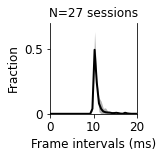

In [7]:
centers = (edges[1:] + edges[:-1])/2

fig = plt.figure(figsize=(2.2, 2))
labelsize = 12
plt.plot(centers, np.median(H, -1), "k-", lw=2)
plt.fill_between(centers, H.min(-1), H.max(-1), color="k", alpha=.3, lw=0)
plt.xlim(0, 20)
plt.xticks((0, 10, 20))
plt.ylim(0, 0.7)
plt.yticks((0, 0.5), ("0", "0.5"))
plt.xlabel("Frame intervals (ms)", fontsize=labelsize)
plt.ylabel("Fraction", fontsize=labelsize)
plt.title(f"N={H.shape[1]} sessions", fontsize=labelsize)
plt.tick_params(labelsize=labelsize)
plt.gca().spines["top"].set_visible(False)

plt.subplots_adjust(bottom=.25, left=.3, right=.85)
outpath = figdir / "frame-intervals.png"
if not figdir.exists():
    figdir.mkdir(parents=True)
fig.savefig(str(outpath), dpi=600)

In [8]:
on_latency  = []
off_latency = []
with h5py.File("latency_data.h5", "r") as src:
    for data in src["on_latency"].values():
        if isinstance(data, h5py.Dataset):
            on_latency.append(np.array(data))
    for data in src["off_latency"].values():
        if isinstance(data, h5py.Dataset):
            off_latency.append(np.array(data))

In [9]:
H_on, edges  = to_histograms(on_latency)
H_off, edges = to_histograms(off_latency)

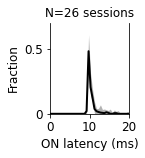

In [10]:
centers = (edges[1:] + edges[:-1])/2

fig = plt.figure(figsize=(2, 2))
labelsize = 12
plt.plot(centers, np.median(H_on, -1), "k-", lw=2)
plt.fill_between(centers, H_on.min(-1), H_on.max(-1), color="k", alpha=.3, lw=0)
plt.xlim(0, 20)
plt.xticks((0, 10, 20))
plt.ylim(0, 0.7)
plt.yticks((0, 0.5), ("0", "0.5"))
plt.xlabel("ON latency (ms)", fontsize=labelsize)
plt.ylabel("Fraction", fontsize=labelsize)
plt.title(f"N={H_on.shape[1]} sessions", fontsize=labelsize)
plt.tick_params(labelsize=labelsize)
plt.gca().spines["top"].set_visible(False)

plt.subplots_adjust(bottom=.25, left=.3, right=.85)
outpath = figdir / "on-latency.png"
if not figdir.exists():
    figdir.mkdir(parents=True)
fig.savefig(str(outpath), dpi=600)

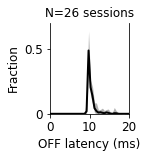

In [11]:
centers = (edges[1:] + edges[:-1])/2

fig = plt.figure(figsize=(2, 2))
labelsize = 12
plt.plot(centers, np.median(H_off, -1), "k-", lw=2)
plt.fill_between(centers, H_off.min(-1), H_off.max(-1), color="k", alpha=.3, lw=0)
plt.xlim(0, 20)
plt.xticks((0, 10, 20))
plt.ylim(0, 0.7)
plt.yticks((0, 0.5), ("0", "0.5"))
plt.xlabel("OFF latency (ms)", fontsize=labelsize)
plt.ylabel("Fraction", fontsize=labelsize)
plt.title(f"N={H_on.shape[1]} sessions", fontsize=labelsize)
plt.tick_params(labelsize=labelsize)
plt.gca().spines["top"].set_visible(False)

plt.subplots_adjust(bottom=.25, left=.3, right=.85)
outpath = figdir / "off-latency.png"
if not figdir.exists():
    figdir.mkdir(parents=True)
fig.savefig(str(outpath), dpi=600)

In [12]:
data = dict()
dt   = 0.1
for attr in ("frame_interval", "on_latency", "off_latency"):
    for typ in ("count", "mean", "std", "min", "2p5", "median", "97p5", "max"):
        data[f"{attr}_{typ}"] = []
for _int, _on, _off in zip(intervals, on_latency, off_latency):
    if _on[_on>0].size < 20:
        continue
    for lab, val in (("frame_interval", _int),
                     ("on_latency", _on[_on>0]),
                     ("off_latency", _off[_off>0])):
        val = val * dt
        data[f"{lab}_count"].append(val.size)
        data[f"{lab}_mean"].append(np.mean(val))
        data[f"{lab}_std"].append(np.std(val, ddof=1))
        data[f"{lab}_min"].append(np.min(val))
        data[f"{lab}_2p5"].append(np.percentile(val, 2.5))
        data[f"{lab}_median"].append(np.median(val))
        data[f"{lab}_97p5"].append(np.percentile(val, 97.5))
        data[f"{lab}_max"].append(np.max(val))
data = pd.DataFrame(data=data)
data.to_csv("latency_stats.tsv", sep="\t", index=False, header=True)

In [13]:
data

frame_interval_count  frame_interval_mean  frame_interval_std  \
0                   6053            10.661441            1.407579   
1                   6035            10.753074            1.403799   
2                   6782            10.254704            0.547360   
3                   5987            11.039135            2.120407   
4                   5948            10.967636            2.017978   
5                   6042            11.098146            1.949479   
6                   6042            10.954667            1.772443   
7                   6029            10.970459            1.786443   
8                   5999            11.274479            2.752069   
9                   5031            10.874518            1.763805   
10                  3037            10.861771            1.785533   
11                  6002            10.870327            1.762058   
12                  4081            10.894756            1.657878   
13                  4546            11.195271            2.204024   
14                  4540            10.881300            1.849619   
15                  3543            10.925684            1.757539   
16                  4539            10.850628            1.578804   
17                  3278            10.861165            1.821818   
18                  3534            10.962988            1.845928   
19                  4013            10.956442            1.798248   
20                  3034            10.847462            1.728648   
21                  5041            10.882285            1.769719   
22                  5549            10.968355            1.986740   
23                  4060            10.990739            1.977626   
24                  4524            10.912069            1.872649   
25                  4324            10.756360            1.425153   

    frame_interval_min  frame_interval_2p5  frame_interval_median  \
0                  9.8              9.9000                   10.2   
1                  9.8              9.9000                   10.3   
2                  9.8              9.9000                   10.1   
3                  9.8              9.9000                   10.4   
4                  9.8             10.0000                   10.4   
5                  9.8             10.0000                   10.6   
6                  9.8             10.0000                   10.4   
7                  9.8             10.0000                   10.5   
8                  9.8              9.9000                   10.5   
9                  9.7              9.9000                   10.3   
10                 9.8              9.9000                   10.3   
11                 9.8              9.9000                   10.3   
12                 9.8              9.9000                   10.4   
13                 9.7              9.9000                   10.5   
14                 9.7              9.9000                   10.3   
15                 9.8              9.9000                   10.3   
16                 9.7              9.9000                   10.3   
17                 9.7              9.9000                   10.3   
18                 9.8              9.9000                   10.3   
19                 9.8              9.9000                   10.4   
20                 9.7              9.9000                   10.3   
21                 9.7              9.9000                   10.3   
22                 9.8              9.9000                   10.3   
23                 9.8              9.9475                   10.4   
24                 9.8              9.9000                   10.4   
25                 9.8              9.9000                   10.3   

    frame_interval_97p5  frame_interval_max  on_latency_count  \
0               14.8000                26.7               403   
1               15.2000                26.3              1113   
2               10.9000                21.0               520   
3               

In [14]:
with open(f"latency_summary_{data.shape[0]}sessions.json", "w") as out:
    stats = data.describe().to_json(indent=4)
    print(stats)
    print(stats, file=out)

{
    "frame_interval_count":{
        "count":26.0,
        "mean":4907.4230769231,
        "std":1122.7457120141,
        "min":3034.0,
        "25%":4065.25,
        "50%":4788.5,
        "75%":6001.25,
        "max":6782.0
    },
    "frame_interval_mean":{
        "count":26.0,
        "mean":10.9025330988,
        "std":0.1838685492,
        "min":10.2547036272,
        "25%":10.8613168798,
        "50%":10.9034125764,
        "75%":10.9681750389,
        "max":11.2744790798
    },
    "frame_interval_std":{
        "count":26.0,
        "mean":1.7824363561,
        "std":0.3694507376,
        "min":0.5473596252,
        "25%":1.7358710265,
        "50%":1.7859877283,
        "75%":1.9302711763,
        "max":2.7520686314
    },
    "frame_interval_min":{
        "count":26.0,
        "mean":9.7730769231,
        "std":0.0452344321,
        "min":9.7,
        "25%":9.725,
        "50%":9.8,
        "75%":9.8,
        "max":9.8
    },
    "frame_interval_2p5":{
        "count":26.